In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import numpy as np
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint

import os
import glob
import scipy

In [85]:
def directory():
    train_dir = "/content/drive/MyDrive/data set/mask dataset/train"
    valid_dir = "/content/drive/MyDrive/data set/mask dataset/valid"
    test_dir = "/content/drive/MyDrive/data set/mask dataset/test"
    return train_dir,valid_dir,test_dir
train_dir,valid_dir,test_dir=directory()

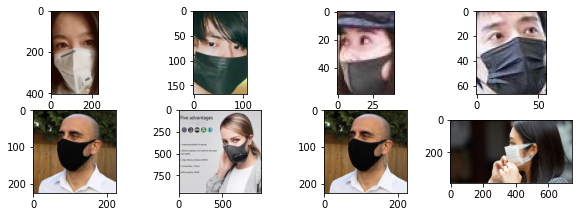

In [86]:
trn_fnames = glob.glob(f'{train_dir}/*/*.jpg')
fig = plt.figure(figsize=(10, 7)) 
  
# setting values to rows and column variables 
rows = 4
columns = 4
for i in range(1,9):
  fig.add_subplot(rows, columns, i) 
  r=np.random.randint(100, size=1)
  img = plt.imread(trn_fnames[int(r)])
  plt.imshow(img);

In [87]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [88]:


def preprocess(train_dir,valid_dir,test_dir,batch_size,target_size,rescale,zoom_range,vertical_flip,rotation_range,width_shift_range,height_shift_range,shear_range):
    train_datagen=ImageDataGenerator(rescale=rescale,zoom_range=zoom_range ,vertical_flip=vertical_flip,rotation_range=rotation_range,width_shift_range=width_shift_range,height_shift_range=height_shift_range,shear_range=shear_range,fill_mode='nearest')
    test_datagen=ImageDataGenerator(rescale=rescale)
    valid_datagen=ImageDataGenerator(rescale=rescale)

    train_generator = train_datagen.flow_from_directory(train_dir,target_size=target_size,batch_size=batch_size,class_mode="binary")

    valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=target_size,batch_size=batch_size,class_mode="binary")

    test_generator = test_datagen.flow_from_directory(test_dir,target_size=target_size,batch_size=batch_size,class_mode="binary")


    return train_generator,valid_generator,test_generator

    
train_set,valid_set,test_set=preprocess(train_dir,valid_dir,test_dir,batch_size=28,target_size=(150,150),rescale=1./255.,zoom_range=0.2,vertical_flip=True,rotation_range=0.2,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2)



Found 11106 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 558 images belonging to 2 classes.


In [89]:
def model(input_shape,activation,lr):
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizers.RMSprop(lr=lr),loss='binary_crossentropy',metrics=['accuracy'])
    return model
model=model(input_shape=(150,150,3),activation='relu',lr=0.0001)

In [90]:
conv_base.trainable = False

In [91]:
def train(train_set,valid_set,epochs,batch_size):
    filepath="weights-improvement1.hdf5"
    checkpoint = ModelCheckpoint(filepath,monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto')
    callbacks_list = [checkpoint]
    history = model.fit_generator(train_set,steps_per_epoch=50, 
           epochs=epochs, validation_data=valid_set,callbacks=callbacks_list)
    return history


train_history=train(train_set,valid_set,epochs=40,batch_size=128)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
50/50 [==============================] - ETA: 0s - loss: 1.3960 - accuracy: 0.5526

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


50/50 [==============================] - 35s 660ms/step - loss: 1.3956 - accuracy: 0.5529 - val_loss: 1.4128 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 1.41285, saving model to weights-improvement1.hdf5
Epoch 2/40
50/50 [==============================] - 32s 638ms/step - loss: 1.2237 - accuracy: 0.7351 - val_loss: 1.0750 - val_accuracy: 0.6870

Epoch 00002: val_loss improved from 1.41285 to 1.07499, saving model to weights-improvement1.hdf5
Epoch 3/40
50/50 [==============================] - 32s 647ms/step - loss: 0.9703 - accuracy: 0.8651 - val_loss: 0.9104 - val_accuracy: 0.8710

Epoch 00003: val_loss improved from 1.07499 to 0.91036, saving model to weights-improvement1.hdf5
Epoch 4/40
50/50 [==============================] - 32s 641ms/step - loss: 0.8077 - accuracy: 0.9286 - val_loss: 0.6869 - val_accuracy: 0.9770

Epoch 00004: val_loss improved from 0.91036 to 0.68694, saving model to weights-improvement1.hdf5
Epoch 5/40
50/50 [=============================

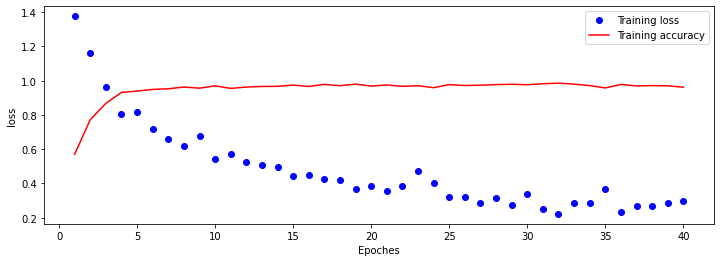

In [92]:
def plot(history,figsize,y,x):
    history_dict=history.history
    loss=history_dict[y]
    acc=history_dict[x]
    epoch=range(1,len(acc)+1)
    plt.figure(figsize=figsize)
    plt.plot(epoch,loss,'bo',label='Training loss')
    plt.plot(epoch,acc,'r',label='Training accuracy')
    plt.xlabel('Epoches')
    plt.ylabel('loss')
    plt.legend()
plot(train_history,(12,4),y='loss',x='accuracy')


In [93]:
def test(test_set):
    results = model.evaluate(test_set)
    return results

results=test(test_set)
print("test set resulat is",results)


20/20 [==============================] - 10s 478ms/step - loss: 0.2544 - accuracy: 0.9516
test set resulat is [0.2544334828853607, 0.9516128897666931]


In [94]:
 def save(name):
     model.save(name)

save("mask")

INFO:tensorflow:Assets written to: mask/assets


In [95]:
model.load_weights("weights-improvement1.hdf5")

In [96]:
    model.compile(optimizer=optimizers.RMSprop(lr=0.0006),loss='binary_crossentropy',metrics=['accuracy'])


In [97]:
def test_best(test_set):
    results = model.evaluate(test_set)
    return results

results=test_best(test_set)
print(results)

20/20 [==============================] - 10s 473ms/step - loss: 0.2993 - accuracy: 0.9753
[0.43977683782577515, 0.9677419066429138]


In [98]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [99]:
model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-5),
metrics=['acc'])
def train(train_set,valid_set,epochs,batch_size):
    filepath="weights-improvement1.hdf5"
    checkpoint = ModelCheckpoint(filepath,monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto')
    callbacks_list = [checkpoint]
    history = model.fit_generator(train_set,steps_per_epoch=50, 
           epochs=epochs, validation_data=valid_set,callbacks=callbacks_list)
    return history


train_history=train(train_set,valid_set,epochs=40,batch_size=64)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
50/50 [==============================] - ETA: 0s - loss: 0.1799 - acc: 0.9910

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


50/50 [==============================] - 29s 549ms/step - loss: 0.1796 - acc: 0.9910 - val_loss: 0.1528 - val_acc: 0.9960

Epoch 00001: val_loss improved from inf to 0.15283, saving model to weights-improvement1.hdf5
Epoch 2/40
50/50 [==============================] - 27s 540ms/step - loss: 0.2168 - acc: 0.9904 - val_loss: 0.1541 - val_acc: 0.9970

Epoch 00002: val_loss did not improve from 0.15283
Epoch 3/40
50/50 [==============================] - 27s 539ms/step - loss: 0.1563 - acc: 0.9938 - val_loss: 0.1526 - val_acc: 0.9960

Epoch 00003: val_loss improved from 0.15283 to 0.15257, saving model to weights-improvement1.hdf5
Epoch 4/40
50/50 [==============================] - 27s 537ms/step - loss: 0.2049 - acc: 0.9901 - val_loss: 0.1541 - val_acc: 0.9960

Epoch 00004: val_loss did not improve from 0.15257
Epoch 5/40
50/50 [==============================] - 27s 548ms/step - loss: 0.1556 - acc: 0.9974 - val_loss: 0.1499 - val_acc: 0.9980

Epoch 00005: val_loss improved from 0.15257 to 

In [100]:
def test_best(test_set):
    results = model.evaluate(test_set)
    return results

results=test_best(test_set)
print(results)

20/20 [==============================] - 9s 469ms/step - loss: 0.4443 - acc: 0.9749
[0.44426265358924866, 0.9749103784561157]


In [101]:
model.load_weights("weights-improvement1.hdf5")
model.compile(optimizer=optimizers.RMSprop(lr=0.0001),loss='binary_crossentropy',metrics=['accuracy'])


In [102]:
def test_best(test_set):
    results = model.evaluate(test_set)
    return results

results=test_best(test_set)
print(results)

20/20 [==============================] - 10s 472ms/step - loss: 0.2954 - accuracy: 0.9783
[0.4513758420944214, 0.9749103784561157]


In [108]:
model.save("maskdet_98")

INFO:tensorflow:Assets written to: maskdet_98/assets


In [107]:
import numpy as np
from keras.preprocessing import image
path='/content/2021-03-06-204915.jpg'
img_width, img_height = 150, 150
img = image.load_img(path, target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

predict=model.predict(img)
print(predict)
if predict[0]==0:
  print ("mask")
if predict[0]==1:
  print ("no mask")

[[1.]]
no mask
